# BC 3

Apex Pattern Deployers

- Marjorie Kinney *m20210647*
- Bruno Mendes *m20210627*
- Lucas Neves *m20211020*
- Farina Pontejos *m20210649*

Business Cases for Data Science

NOVA Information Management School

April 2022

## Initial Setup

### Imports


In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import ceil
from datetime import timedelta, datetime
import os
import re
import warnings
warnings.filterwarnings('ignore')

from matplotlib.colors import LinearSegmentedColormap

In [2]:
# import nltk

import nltk
# nltk.download('omw-1.4')

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction import text


### Variables

In [3]:
COLORS = ['#e06666', '#e88b81', '#f0ad9a', '#f8ceb2', '#ffeeca', '#c6cfbf', '#8fb0ae', '#58919d', '#20718b']

CAT_COLORS = ['#20718b', '#7DB082', '#FAEC73', '#ECA052', '#e06666']
CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = ['#e06666', '#e68d8d', '#ebb1b1', '#efd3d3', '#f4f4f4', '#bed3da', '#8ab2bf', '#5592a5', '#20718b']

UMP_COLORS = ['#22446D', '#FC9E4F', '#AB2346' ,'#6ABB5D']

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)
CAT_PALETTE = sns.color_palette(CAT_COLORS)
UMP_PALETTE = sns.color_palette(UMP_COLORS)


DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)
CAT_CMAP = LinearSegmentedColormap.from_list("cat_colors", CAT_COLORS)
UMP_CMAP = LinearSegmentedColormap.from_list("ump_colors", UMP_COLORS)


SHOW_PLOTS = True
SAVE_PLOTS = True
RANDOM_STATE = 9

IMG_PATH = 'imgs/'
DATA_PATH = 'data/'


In [4]:
## Function to plot histograms of numeric features for specified dfframe
def plot_histograms_boxplots(df, features, rows=4, title = "Histograms of Numeric Variables"):
    if SHOW_PLOTS:
        cols = ceil(len(features) / rows)
        fig = plt.figure(figsize=(4*cols,4*rows),
                         constrained_layout=True)
        
        subfigs = fig.subfigures(rows, cols)
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(2, 1, sharex=True, \
                                gridspec_kw={'height_ratios': [4,1]})
        
            axs[0].hist(df[feat], color=COLORS[0])
            axs[0].set_ylabel(None)
            axs[0].set_title(feat, y=1, fontsize=6*rows)
        
            axs[1].set_xlabel(None)
            flierprops = dict(markerfacecolor='None', markersize=6,  markeredgecolor=COLORS[0])
            sns.boxplot(x=df[feat], ax=axs[1], color=COLORS[0], flierprops=flierprops)
            axs[1].set_xlabel(None)

            subf.suptitle(None)
        
        plt.suptitle(title, fontsize=8*rows)
        if SAVE_PLOTS:
            save_fig(title, fig)
        
        plt.show()
    else:
        print("show_plots is currently set to False")

### Styles

In [5]:
sns.set(style="white")

sns.set_context("paper")
sns.set_palette(DEFAULT_PALETTE)


plt.rcParams['figure.dpi'] = 128

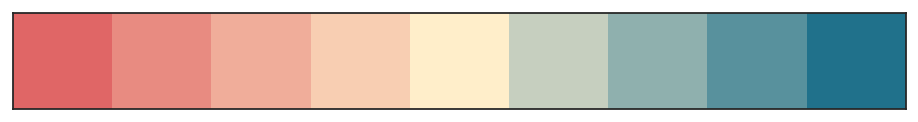

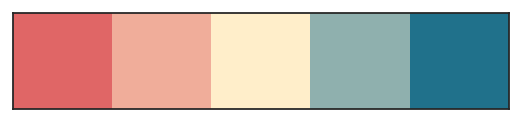

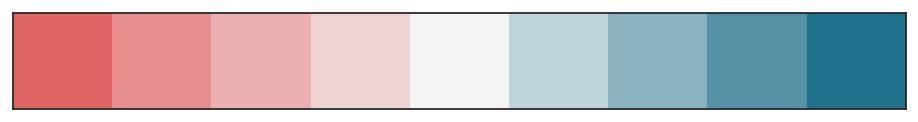

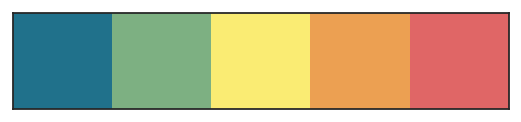

In [6]:
sns.palplot(DEFAULT_PALETTE)
sns.palplot(CONTRAST_PALETTE)
sns.palplot(DIVERGENT_PALETTE)
sns.palplot(CAT_PALETTE)
plt.show()

## Load df

In [7]:
df = pd.read_csv("../../source/retail.csv")
df_orig = df.copy()

In [8]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [9]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [10]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

## Data Understanding

In [11]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [12]:
## Add IsCancelled column

df['IsCancelled'] = False
df.loc[df['InvoiceNo'].str.startswith("C"),['IsCancelled']] = True


In [13]:
print(round(df['CustomerID'].isna().sum()/df.shape[0]*100,2), "% of CustomerID column is NULL.")


24.93 % of CustomerID column is NULL.


In [14]:
## Fill NaN customer id with 0 
df['CustomerID'] = df['CustomerID'].fillna(0)

In [15]:
df['CustomerID'] = df['CustomerID'].astype(int)

In [16]:
df.loc[df['CustomerID'].isna(),:].groupby(['InvoiceNo']).size()

Series([], dtype: int64)

In [17]:
inv_cust = df.loc[:,['InvoiceNo','CustomerID', 'IsCancelled','Quantity']]
inv_cust['CustomerID'] = inv_cust['CustomerID'].fillna('NA')
inv_cust['combi']=inv_cust['InvoiceNo'].astype(str)+"__"+inv_cust['CustomerID'].astype(str)


In [18]:
print("Number of unique InvoiceNo:")
len(inv_cust['InvoiceNo'].unique())


Number of unique InvoiceNo:


25900

In [19]:
print("Number of unique combinations of InvoiceNo + CustomerID:")
len(inv_cust['combi'].unique())


Number of unique combinations of InvoiceNo + CustomerID:


25900

In [20]:
print("Number of unique CustomerID:")
len(inv_cust['CustomerID'].unique())

Number of unique CustomerID:


4373

Drop NULL CustomerID? Or treat as one customer?


In [21]:
print("Number of unique InvoiceNo for NULL CustomerID")
len(inv_cust.loc[inv_cust['CustomerID']==0,'InvoiceNo'].unique())

Number of unique InvoiceNo for NULL CustomerID


3710

In [22]:
print('Percent of Invoices with NULL CustomerID')
round(100*len(inv_cust.loc[inv_cust['CustomerID']==0,'InvoiceNo'].unique())/len(inv_cust['combi'].unique()),2)


Percent of Invoices with NULL CustomerID


14.32

In [23]:
print('Percent of Cancelled Invoices with NULL CustomerID')
round(100*len(inv_cust.loc[(inv_cust['CustomerID']==0)&(inv_cust['IsCancelled']==True),'InvoiceNo'].unique())\
          /len(inv_cust['combi'].unique()),2)


Percent of Cancelled Invoices with NULL CustomerID


0.7

### Remove invoice lines with non-product lines

In [24]:
unique_stockcode = pd.DataFrame(df.groupby(['StockCode','Description']).size()).reset_index().loc[:,['StockCode','Description']]#.reset_index()
unique_stockcode.to_csv('unique_stockcodes.csv')

In [25]:
filtered_stockcodes = pd.read_csv('../unique_stock.csv')
filtered_stockcodes = filtered_stockcodes.fillna(0)
filtered_stockcodes['Remove'] = filtered_stockcodes['Remove'].astype(int)
filtered_stockcodes['StockCodeDescription'] = filtered_stockcodes['StockCode']+'__'+filtered_stockcodes['Description']

remove_stockcodes = filtered_stockcodes.loc[:,['StockCodeDescription','Remove']]
df['StockCodeDescription'] = df['StockCode']+'__'+df['Description']
df = df.merge(right=remove_stockcodes, on="StockCodeDescription", how='left')


In [26]:
df_removed_sd = df.loc[df['Remove']==1]
print('Rows removed with non-product descriptions:')
print(len(df_removed_sd))

df = df.loc[df['Remove']==0].drop(columns=['Remove', 'StockCodeDescription']).reset_index(drop=True)

Rows removed with non-product descriptions:
3640


### Distribution of customer purchases

In [27]:
df['Value'] = df['Quantity']*df['UnitPrice']

In [28]:
#val_hist = val_hist.loc[val_hist['Quantity']<=1000,:].loc[size_hist['Quantity']>0,:]
#val_hist.describe()

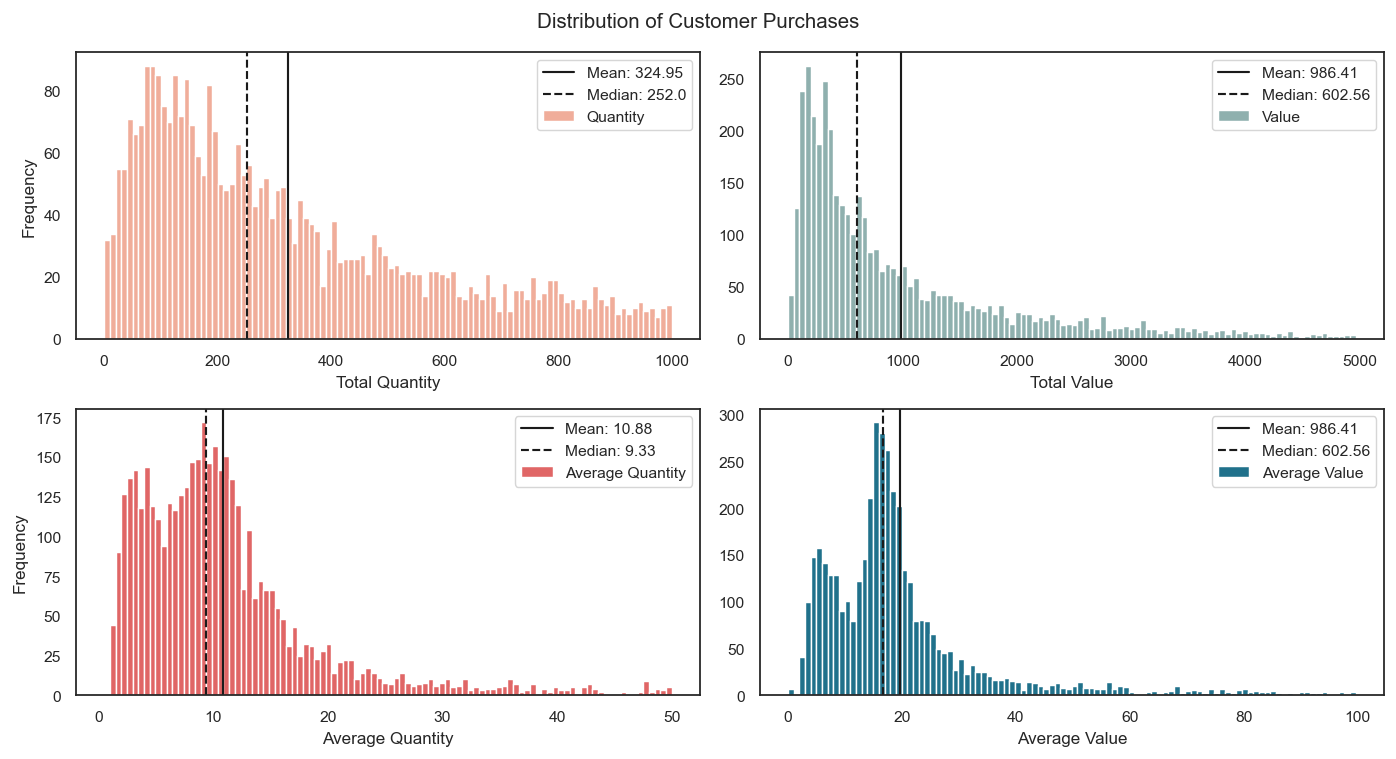

In [29]:
fig, ax = plt.subplots(2,2, figsize=(11,6))

size_hist = pd.DataFrame(df.groupby(['CustomerID']).sum()['Quantity'],columns=['Quantity'])
size_hist = size_hist.loc[size_hist['Quantity']<=1000,:].loc[size_hist['Quantity']>0,:]

ax[0][0].hist(size_hist, bins=100, label='Quantity', color=COLORS[2])

size_h_mean_label = "Mean: " + str(round(size_hist['Quantity'].mean(),2))
size_h_median_label = "Median: " + str(round(size_hist['Quantity'].median(),2))

ax[0][0].axvline(size_hist['Quantity'].mean(), color='k', label=size_h_mean_label)
ax[0][0].axvline(size_hist['Quantity'].median(), color='k', linestyle='--', label=size_h_median_label)
ax[0][0].set_xlabel('Total Quantity')
ax[0][0].set_ylabel('Frequency')
ax[0][0].legend()

val_hist = pd.DataFrame(df.loc[df['CustomerID']!=0].groupby(['CustomerID']).sum()['Value'],columns=['Value'])
val_hist = val_hist.loc[(val_hist['Value']<=5000)&(val_hist['Value']>0),:] #.loc[size_hist['Value']>0,:]


ax[0][1].hist(val_hist, bins=100, color=COLORS[-3], label='Value')

v_h_mean_label = "Mean: " + str(round(val_hist['Value'].mean(),2))
v_h_median_label = "Median: " + str(round(val_hist['Value'].median(),2))

ax[0][1].axvline(val_hist['Value'].mean(), color='k', label=v_h_mean_label)
ax[0][1].axvline(val_hist['Value'].median(), color='k', linestyle='--', label=v_h_median_label)
ax[0][1].set_xlabel('Total Value')
#ax[0][1].set_ylabel('Frequency')
ax[0][1].legend()



######## Averages

size_ave = pd.DataFrame(df.groupby(['CustomerID']).mean()['Quantity'],columns=['Quantity'])
size_ave = size_ave.loc[size_ave['Quantity']<=50,:].loc[size_ave['Quantity']>0,:]

ax[1][0].hist(size_ave, bins=100, label='Average Quantity', color=COLORS[0])

size_h_mean_label2 = "Mean: " + str(round(size_ave['Quantity'].mean(),2))
size_h_median_label2 = "Median: " + str(round(size_ave['Quantity'].median(),2))

ax[1][0].axvline(size_ave['Quantity'].mean(), color='k', label=size_h_mean_label2)
ax[1][0].axvline(size_ave['Quantity'].median(), color='k', linestyle='--', label=size_h_median_label2)
ax[1][0].set_xlabel('Average Quantity')
ax[1][0].set_ylabel('Frequency')
ax[1][0].legend()



val_hist_ave = pd.DataFrame(df.loc[df['CustomerID']!=0].groupby(['CustomerID']).mean()['Value'],columns=['Value'])
val_hist_ave = val_hist_ave.loc[(val_hist_ave['Value']<=100)&(val_hist_ave['Value']>0),:] #.loc[size_hist['Value']>0,:]


ax[1][1].hist(val_hist_ave, bins=100, color=COLORS[-1], label='Average Value')

v_h_mean_label2 = "Mean: " + str(round(val_hist['Value'].mean(),2))
v_h_median_label2 = "Median: " + str(round(val_hist['Value'].median(),2))

ax[1][1].axvline(val_hist_ave['Value'].mean(), color='k', label=v_h_mean_label2)
ax[1][1].axvline(val_hist_ave['Value'].median(), color='k', linestyle='--', label=v_h_median_label2)
ax[1][1].set_xlabel('Average Value')
#ax[1][1].set_ylabel('Frequency')
ax[1][1].legend()



fig.suptitle('Distribution of Customer Purchases')

plt.tight_layout()
plt.show()

#size_hist


In [30]:
invoice_hist = pd.DataFrame(df.loc[df['CustomerID']!=0].groupby(['CustomerID']).mean()['Value'],columns=['Value'])
invoice_hist = invoice_hist.loc[(invoice_hist['Value']<=100)&(invoice_hist['Value']>0),:] #.loc[size_hist['Value']>0,:]




In [31]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled,Value
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,False,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,False,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,False,22.00


In [32]:
datetime.today()

datetime.datetime(2022, 4, 6, 16, 47, 47, 571227)

In [33]:
rfm = df.loc[df['CustomerID']!=0,:].groupby("CustomerID").agg(
    val_tot=pd.NamedAgg(column="Value", aggfunc="sum"),
    val_ave=pd.NamedAgg(column="Value", aggfunc="mean"),
    qty_tot=pd.NamedAgg(column="Quantity", aggfunc="sum"),
    qty_ave=pd.NamedAgg(column="Quantity", aggfunc="mean"),
    qty_count=pd.NamedAgg(column="Quantity", aggfunc="count"),
    last_purch=pd.NamedAgg(column="InvoiceDate", aggfunc="max"),
    )

rfm['recency'] = rfm['last_purch'].apply( lambda x: (datetime.today() - x).days)
rfm['frequency'] = rfm['qty_count']
rfm['monetary'] = rfm['val_tot']

rfm

,val_tot,val_ave,qty_tot,qty_ave,qty_count,last_purch,recency,frequency,monetary
CustomerID,,,,,,,,,
12346,0.00,0.000000,0,0.000000,2,2011-01-18 10:17:00,4096,2,0.00
12347,4310.00,23.681319,2458,13.505495,182,2011-12-07 15:52:00,3773,182,4310.00
12348,1437.24,53.231111,2332,86.370370,27,2011-09-25 13:13:00,3846,27,1437.24
12349,1457.55,20.243750,630,8.750000,72,2011-11-21 09:51:00,3789,72,1457.55
12350,294.40,18.400000,196,12.250000,16,2011-02-02 16:01:00,4081,16,294.40
...,...,...,...,...,...,...,...,...,...
18280,180.60,18.060000,45,4.500000,10,2011-03-07 09:52:00,4048,10,180.60
18281,80.82,11.545714,54,7.714286,7,2011-06-12 10:53:00,3951,7,80.82
18282,176.60,13.584615,98,7.538462,13,2011-12-02 11:43:00,3778,13,176.60


In [34]:
#df_lower = df[df.Description.str.islower().fillna(False)]
#df_lower['Description'].unique()

In [35]:
#set1 = df['StockCode'].unique()[0:1000]
#set2 = df['StockCode'].unique()[1000:2000]
#set3 = df['StockCode'].unique()[2000:3000]
#set4 = df['StockCode'].unique()[3000:]



## Reduce Sparsity

### Remove stop words

In [36]:
stop = text.ENGLISH_STOP_WORDS

In [37]:
print(pd.Series(' '.join(df['Description']).lower().split()).value_counts()[:100])

set        54575
of         53351
bag        51911
red        42902
heart      38714
           ...  
cup         5048
candles     5046
hearts      5023
jam         4997
knob        4953
Length: 100, dtype: int64


In [38]:
df_descriptions = df.copy()

In [39]:
common_words = pd.DataFrame(pd.Series(' '.join(df['Description']).lower().split()).value_counts()[:100], columns=['common'])

In [40]:
stop2 = ['SET', 'OF', 'OF4', 'IN', 'AND', 'ASSORTED', 'KIT', 
         'WITH', '12', '4', '3' '2', '60CM', '60x40CM', '60', '6',
         'SET/6', 'S/6', '10', 'SET/2', 'SET/20', 'SET/12', 'SET/10',
         'SET/20','SET/3','SET/4','SET/5','SET/9','SET3',
         'S/2','S/12','S/72', 'S/3','S/4',
         'PACK','PACK/12', 'PACK/2'
        ]



In [41]:
print(common_words.index.tolist())

['set', 'of', 'bag', 'red', 'heart', 'retrospot', 'vintage', 'design', 'pink', 'christmas', 'box', 'cake', 'jumbo', 'metal', 'white', 'blue', '3', 'lunch', 'hanging', 'sign', 'holder', 'pack', 't-light', 'paper', 'small', 'card', '6', 'decoration', 'wooden', 'polkadot', 'glass', 'cases', 'tea', 'bottle', '12', 'in', 'and', 'spaceboy', 'hot', 'water', 'with', 'large', 'pantry', 'home', 'tin', 'rose', 'paisley', 'ceramic', '4', 'regency', 'green', 'dolly', 'doormat', 'mug', 'ivory', 'mini', 'cream', 'bunting', 'love', 'girl', 'assorted', 'party', 'clock', 'feltcraft', 'black', 'wicker', 'bowl', 'garden', 'kit', 'tins', 'woodland', 'fairy', 'wrap', 'frame', 'antique', 'drawer', 'charlotte', 'silver', 'colour', 'childrens', 'wall', 'birthday', 'strawberry', 'star', 'wood', '60', 'bird', 'zinc', 'union', 'gift', 'cutlery', 'jar', 'flower', '2', 'suki', 'cup', 'candles', 'hearts', 'jam', 'knob']


In [42]:
df_descriptions['no_stop'] = df_descriptions['Description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_descriptions['no_stop'] = df_descriptions['no_stop'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop2)]))
df_descriptions['no_stop'] = df_descriptions['no_stop'].str.replace('  ', ' ')


In [43]:
## Remove symbols
df_descriptions['no_stop'] = df_descriptions['no_stop'].replace(r'[^A-Za-z0-9 ]+', '', regex=True)

## Remove digits
df_descriptions['no_stop'] = df_descriptions['no_stop'].str.replace(r'\d+','')

#df_descriptions['trimmed'] = df_descriptions['no_stop']
df_descriptions['no_stop'] = df_descriptions['no_stop'].str.replace(' 72', '')
df_descriptions['no_stop'] = df_descriptions['no_stop'].str.replace('72 ', '')
df_descriptions['no_stop'] = df_descriptions['no_stop'].str.replace(' 12', '')
df_descriptions['no_stop'] = df_descriptions['no_stop'].str.replace('200', '')
df_descriptions['no_stop'] = df_descriptions['no_stop'].str.replace('20', '')
df_descriptions['no_stop'] = df_descriptions['no_stop'].str.replace(' 2', ' ')
df_descriptions['no_stop'] = df_descriptions['no_stop'].str.replace('2 ', ' ')
df_descriptions['no_stop'] = df_descriptions['no_stop'].str.replace('3 ', '')
df_descriptions['no_stop'] = df_descriptions['no_stop'].str.replace('36 ', '')


In [44]:
#print(pd.Series(' '.join(df_descriptions['no_stop']).lower().split()).value_counts()[:100].index.tolist())

In [45]:
#sorted(df_descriptions.loc[df_descriptions['trimmed'].str.contains('6'),'trimmed'].unique())#.head(5)

In [46]:
print(len(df_descriptions['Description'].unique()))
print(len(df_descriptions['no_stop'].unique()))


4029
3954


In [47]:
#df_descriptions.head()

### Use stemming

In [48]:
stemmer = PorterStemmer()

In [49]:
df_descriptions['stemmed'] = df_descriptions['no_stop'].str.lower()

In [50]:
def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

In [51]:
df_descriptions['stemmed'] = df_descriptions['stemmed'].apply(stem_sentences)

In [52]:
len(df_descriptions['stemmed'].unique())

3924

In [53]:
df_descriptions['stemmed']

0          white hang heart tlight holder
1                     white metal lantern
2           cream cupid heart coat hanger
3         knit union flag hot water bottl
4            red woolli hotti white heart
                       ...               
536810                    spaceboy napkin
536811          children apron dolli girl
536812        children cutleri dolli girl
536813       children cutleri circu parad
536814                bake piec retrospot
Name: stemmed, Length: 536815, dtype: object

### Use lemmatizer

In [54]:
lemmatizer = WordNetLemmatizer()

def lemmatize_sentences(sentence):
    tokens = sentence.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)


In [55]:
df_descriptions['lemmatized'] = df_descriptions['no_stop'].str.lower()

In [56]:
df_descriptions['lemmatized'] = df_descriptions['lemmatized'].apply(lemmatize_sentences)

## Market Basket

In [57]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


In [58]:
df_basket = df_descriptions.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

In [59]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

df_basket_sets = df_basket.applymap(encode_units)

In [60]:
df_basket_sets

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY,lost in space
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C581470,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C581484,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C581490,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
frequent_itemsets = apriori(df_basket_sets, min_support=0.01, use_colnames=True)


In [62]:
frequent_itemsets

,support,itemsets
0,0.011589,( SET 2 TEA TOWELS I LOVE LONDON )
1,0.013700,(10 COLOUR SPACEBOY PEN)
2,0.010813,(12 MESSAGE CARDS WITH ENVELOPES)
3,0.015294,(12 PENCIL SMALL TUBE WOODLAND)
4,0.015595,(12 PENCILS SMALL TUBE RED RETROSPOT)
...,...,...
1250,0.010426,"(CHARLOTTE BAG PINK POLKADOT, STRAWBERRY CHARL..."
1251,0.011201,"(STRAWBERRY CHARLOTTE BAG, CHARLOTTE BAG SUKI ..."
1252,0.012967,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC..."
1253,0.010081,"(JUMBO STORAGE BAG SUKI, JUMBO BAG RED RETROSP..."


In [63]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(JAM MAKING SET PRINTED),(6 RIBBONS RUSTIC CHARM),0.050060,0.041143,0.010167,0.203098,4.936454,0.008108,1.203232
1,(6 RIBBONS RUSTIC CHARM),(JAM MAKING SET PRINTED),0.041143,0.050060,0.010167,0.247120,4.936454,0.008108,1.261742
2,(6 RIBBONS RUSTIC CHARM),(PACK OF 72 RETROSPOT CAKE CASES),0.041143,0.056867,0.010253,0.249215,4.382402,0.007914,1.256195
3,(PACK OF 72 RETROSPOT CAKE CASES),(6 RIBBONS RUSTIC CHARM),0.056867,0.041143,0.010253,0.180303,4.382402,0.007914,1.169771
4,(REGENCY CAKESTAND 3 TIER),(6 RIBBONS RUSTIC CHARM),0.085688,0.041143,0.010426,0.121669,2.957262,0.006900,1.091681
...,...,...,...,...,...,...,...,...,...
1683,"(JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO BAG ...","(JUMBO STORAGE BAG SUKI, JUMBO BAG RED RETROSPOT)",0.020162,0.031191,0.011546,0.572650,18.359588,0.010917,2.267014
1684,(JUMBO STORAGE BAG SUKI),"(JUMBO BAG RED RETROSPOT, JUMBO SHOPPER VINTAG...",0.051008,0.016285,0.011546,0.226351,13.899650,0.010715,1.271527
1685,(JUMBO BAG RED RETROSPOT),"(JUMBO STORAGE BAG SUKI, JUMBO SHOPPER VINTAGE...",0.090126,0.013312,0.011546,0.128107,9.623370,0.010346,1.131662
1686,(JUMBO SHOPPER VINTAGE RED PAISLEY),"(JUMBO STORAGE BAG SUKI, JUMBO BAG RED RETROSP...",0.050620,0.017793,0.011546,0.228085,12.819156,0.010645,1.272430


In [64]:
df_basket_l = df_descriptions.groupby(['InvoiceNo', 'lemmatized'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')


In [65]:
df_basket_sets_l = df_basket_l.applymap(encode_units)

In [66]:
frequent_itemsets_l = apriori(df_basket_sets_l, min_support=0.01, use_colnames=True)


In [67]:
rules_l = association_rules(frequent_itemsets_l, metric="lift", min_threshold=1)
rules_l

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(alarm clock bakelike chocolate),(alarm clock bakelike green),0.018439,0.042220,0.011933,0.647196,15.329306,0.011155,2.714768
1,(alarm clock bakelike green),(alarm clock bakelike chocolate),0.042220,0.018439,0.011933,0.282653,15.329306,0.011155,1.368322
2,(alarm clock bakelike chocolate),(alarm clock bakelike red),0.018439,0.045278,0.012580,0.682243,15.067768,0.011745,3.004565
3,(alarm clock bakelike red),(alarm clock bakelike chocolate),0.045278,0.018439,0.012580,0.277831,15.067768,0.011745,1.359184
4,(alarm clock bakelike ivory),(alarm clock bakelike green),0.024556,0.042220,0.014389,0.585965,13.878997,0.013352,2.313283
...,...,...,...,...,...,...,...,...,...
1725,"(jumbo storage bag suki, jumbo bag pink polkadot)","(jumbo bag red retrospot, jumbo shopper vintag...",0.022187,0.029295,0.011546,0.520388,17.763609,0.010896,2.023939
1726,(jumbo bag red retrospot),"(jumbo storage bag suki, jumbo shopper vintage...",0.090126,0.013312,0.011546,0.128107,9.623370,0.010346,1.131662
1727,(jumbo shopper vintage red paisley),"(jumbo bag red retrospot, jumbo storage bag su...",0.050620,0.017793,0.011546,0.228085,12.819156,0.010645,1.272430
1728,(jumbo storage bag suki),"(jumbo bag red retrospot, jumbo shopper vintag...",0.051008,0.016285,0.011546,0.226351,13.899650,0.010715,1.271527


In [68]:
rules_l.loc[(rules_l['lift']>10) &
            (rules_l['confidence']>.8)
           ]


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
220,(pink regency teacup saucer),(green regency teacup saucer),0.033000,0.043727,0.027270,0.826371,18.898244,0.025827,5.507555
894,(red spotty paper cup),(red spotty paper plate),0.018439,0.022704,0.015078,0.817757,36.018550,0.014660,5.362600
914,(regency tea plate pink),(regency tea plate green),0.013140,0.016414,0.011977,0.911475,55.530623,0.011761,11.110880
917,(regency tea plate green),(regency tea plate rose),0.016414,0.019171,0.013743,0.837270,43.673526,0.013428,6.027352
918,(regency tea plate pink),(regency tea plate rose),0.013140,0.019171,0.011589,0.881967,46.004995,0.011337,8.309800
977,(wooden tree christmas scandinavian),(wooden star christmas scandinavian),0.014561,0.022058,0.012106,0.831361,37.690528,0.011785,5.799027
991,"(charlotte bag pink polkadot, charlotte bag su...",(red retrospot charlotte bag),0.017663,0.044546,0.014174,0.802439,18.013747,0.013387,4.836249
1014,"(charlotte bag pink polkadot, strawberry charl...",(red retrospot charlotte bag),0.016328,0.044546,0.014044,0.860158,19.309473,0.013317,6.832398
1020,"(charlotte bag pink polkadot, woodland charlot...",(red retrospot charlotte bag),0.017017,0.044546,0.014001,0.822785,18.470485,0.013243,5.391491
1039,"(strawberry charlotte bag, charlotte bag suki ...",(red retrospot charlotte bag),0.017879,0.044546,0.014389,0.804819,18.067181,0.013593,4.895228


In [69]:
rules.loc[(rules['lift']>10) &
            (rules['confidence']>.8)
           ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
197,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.033000,0.043727,0.027270,0.826371,18.898244,0.025827,5.507555
892,(REGENCY TEA PLATE PINK),(REGENCY TEA PLATE GREEN ),0.013140,0.016414,0.011977,0.911475,55.530623,0.011761,11.110880
895,(REGENCY TEA PLATE GREEN ),(REGENCY TEA PLATE ROSES ),0.016414,0.019171,0.013743,0.837270,43.673526,0.013428,6.027352
897,(REGENCY TEA PLATE PINK),(REGENCY TEA PLATE ROSES ),0.013140,0.019171,0.011589,0.881967,46.004995,0.011337,8.309800
938,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.018439,0.022704,0.015078,0.817757,36.018550,0.014660,5.362600
964,(WOODEN TREE CHRISTMAS SCANDINAVIAN),(WOODEN STAR CHRISTMAS SCANDINAVIAN),0.014561,0.022058,0.012106,0.831361,37.690528,0.011785,5.799027
978,"(CHARLOTTE BAG PINK POLKADOT, CHARLOTTE BAG SU...",(RED RETROSPOT CHARLOTTE BAG),0.017663,0.044546,0.014174,0.802439,18.013747,0.013387,4.836249
1002,"(CHARLOTTE BAG PINK POLKADOT, STRAWBERRY CHARL...",(RED RETROSPOT CHARLOTTE BAG),0.016328,0.044546,0.014044,0.860158,19.309473,0.013317,6.832398
1008,"(CHARLOTTE BAG PINK POLKADOT, WOODLAND CHARLOT...",(RED RETROSPOT CHARLOTTE BAG),0.017017,0.044546,0.014001,0.822785,18.470485,0.013243,5.391491
1026,"(STRAWBERRY CHARLOTTE BAG, CHARLOTTE BAG SUKI ...",(RED RETROSPOT CHARLOTTE BAG),0.017879,0.044546,0.014389,0.804819,18.067181,0.013593,4.895228
